# ** Facial Recognition Challenge - Solution**

In this notebook I will describe my workflow and thought process for achieving a top 3 score in the Purdue Facial Recognition challenege. My goal is to share insights into the techniques and strategies that helped me succeed. Included you will find explanations for data pre-processing, feature extractor selection, model tuning, and evaluation procedures.

# **Supervised Learning Diagram**

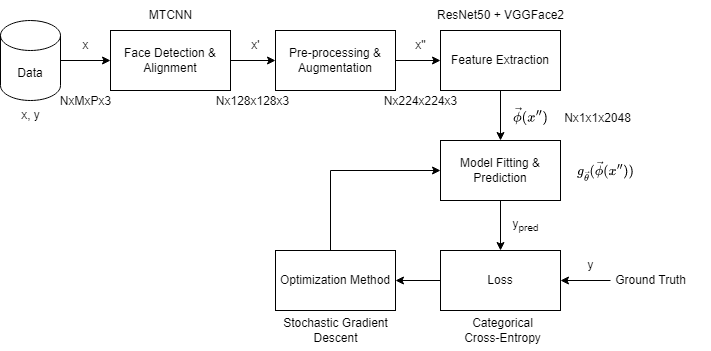

The above figure depicts the supervised learning diagram (that we have studied in lecture) outlining the specific methods used in this solution.

Facial detection and alignment of the training dataset is performed using [MTCNN](https://arxiv.org/abs/1604.02878). Pre-processing of the images is performed to match the expected input of the models. These detections are split into training and validation datasets to observe/predict performance on unseen images that will be present in the testing dataset.

Feature extraction on the detected faces is performed using the ResNet50 architecture trained on the [VGGFace2](https://www.robots.ox.ac.uk/~vgg/publications/2018/Cao18/cao18.pdf) dataset. Transfer learning is performed on the extracted face embeddings to adapt the model to our specific classification problem. This is done through the addition of trainable, fully-connected layers to the model for learning and classification.

The predictions and truth labels are fed into the loss function of the model and the optimizer adjusts the model's parameters to minimize the loss. A categorical cross-entropy loss is used for multi-class classification, and SGD with a reduced learning rate is used as the optimizer.

In order to improve robustness to noise, the training set of the face detections is [augmented](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) with small amounts of rotation, changes in brightness, and mirroring.

Once the model has been trained for the desired number of epochs, the face detections of the testing dataset are fed into the model. Finally, the resulting predictions are output for submission.

# **Required Libraries**

To begin, the following cells install and import the libraries and models required for the various function used. Installing the modules guarantees the correct version number is being used in a cloud-computing environment. Pre-computed data and models are available in the provided link, where computationally expensive cells will check for these files before running.

In [ ]:
!pip install facenet_pytorch -q
!pip install git+https://github.com/rcmalli/keras-vggface.git -q
!pip install keras_applications --no-deps -q
!pip install natsort -q

  Preparing metadata (setup.py) ... done


In [ ]:
!gdown --id 1Nd1RvrOvs_kwQJQ0YN2j4x5BNMHisF15
!unzip facial_recognition.zip

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Nd1RvrOvs_kwQJQ0YN2j4x5BNMHisF15
To: /content/facial_recognition.zip
100% 3.06G/3.06G [00:19<00:00, 161MB/s]
Archive:  facial_recognition.zip
replace category.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cropped_faces_resnet.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace eval_resnet.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace trained_model_resnet.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace trained_model_resnet50/trained_model_new/fingerprint.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace trained_model_resnet50/trained_model_new/keras_metadata.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace trained_model_resnet50/trained_model

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from natsort import natsorted

from PIL import Image
from facenet_pytorch import MTCNN
import os
import shutil

import torch
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input

from keras_vggface.vggface import VGGFace
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Resizing, Dropout
from keras.preprocessing.image import ImageDataGenerator

# **Importing Training Data**

Here the training data filenames and labels, and the mapping of the labels is imported

In [ ]:
train_path = 'train.csv'
label_dict_path = 'category.csv'

train_truth = pd.read_csv(train_path)
label_df = pd.read_csv(label_dict_path)

label_dict_map = label_df.Category.to_dict()
label_dict_map_rev = {v: k for k, v in label_dict_map.items()}

y = train_truth.Category.map(label_dict_map_rev)

To improve model performance, face detection and alignment is performed using [MTCNN](https://towardsdatascience.com/face-detection-using-mtcnn-a-guide-for-face-extraction-with-a-focus-on-speed-c6d59f82d49). Training images are loaded in using PIL and immediately converted to RGB which is the expected format for MTCNN. A cropped face image size of 128x128 is output due to memory constraints, but likely has margin for increasing. The outputs are appended to a data matrix that is converted to an 8-bit unsigned integer to also save memory.

The dataset contains noise and includes images that aren't faces. If a face isn't detected, then the index of the image is stored and ultimately removed from the training data.

In [ ]:
train_data_path = '' # Add path to training images if not using pre-cropped face detections

# Load cropped face detection data
if os.path.isfile('cropped_faces_resnet.npz'):
    data_input = np.load('cropped_faces_resnet.npz')

    X_train, y_train, X_val, y_val = data_input['arr_0'], data_input['arr_1'], data_input['arr_2'], data_input['arr_3']
    print('Loaded: ',X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# Generate cropped face detections
else:
    print('Generating Face Detections')
    X = []
    index = []

    mtcnn = MTCNN(
        image_size = 128, margin=0, post_process=False, device='cuda:0'
    )

    for idx, i in enumerate(train_truth['File Name']):
        img = Image.open(train_data_path + i).convert('RGB')
        try: # Detect and save cropped faces
            img_cropped = mtcnn(img)
            img = img_cropped.cpu().detach().numpy().transpose(1,2,0)
            X.append(np.asarray(img).astype(np.uint8))

        except: # Save indices of images without a detected face
            index.append(idx)

    X = np.asarray(X)
    y_new = y.drop(index).reset_index(drop=True) # Drop images without a detected face from the training set

    X_train, X_val, y_train, y_val = train_test_split(
        X, y_new, test_size=0.25, random_state=42, stratify = y_new
    )

    np.savez_compressed('cropped_faces_resnet.npz', X_train, y_train, X_val, y_val)

Loaded:  (48642, 128, 128, 3) (48642,) (16214, 128, 128, 3) (16214,)


The model used expects an image size of 224x224 as float32, but due to memory contraints in Colab, all 65k training images cannot be stored in memory simultaneously. To combat this, the cropped images are saved in the session storage and data generators are used to flow the images from a directory during training. This has the added benefit of performing data augmentation to increase the noise of the training data to prevent overfitting.

In [ ]:
if os.path.isdir('faces/train'):
    shutil.rmtree('faces/train')

if os.path.isdir('faces/val'):
    shutil.rmtree('faces/val')

os.makedirs('faces/train')
os.makedirs('faces/val')

for i in range(len(X_train)):
    if not os.path.isdir('faces/train/' + label_dict_map[y_train[i]]):
        os.mkdir('faces/train/' + label_dict_map[y_train[i]])

    Image.fromarray(X_train[i]).save('faces/train/' + label_dict_map[y_train[i]] +'/' + str(i) + '.jpg')

for i in range(len(X_val)):
    if not os.path.isdir('faces/val/' + label_dict_map[y_val[i]]):
        os.mkdir('faces/val/' + label_dict_map[y_val[i]])

    Image.fromarray(X_val[i]).save('faces/val/' + label_dict_map[y_val[i]] +'/' + str(i) + '.jpg')


# **Building the Model**

# Base Model:
The base model used for this solution is based on the ResNet50 architecture and was primarily chosen due to being trained on the [VGGFace2](https://www.robots.ox.ac.uk/~vgg/publications/2018/Cao18/cao18.pdf) dataset. VGGFace2 is one of the largest face datasets (2018) with 3.3M images. More importantly, the number of subjects, ~9000, is orders of magnitude lower than similarly sized dataset and includes a variety of poses and ages of the subjects.

The intention is that this model has likely been trained to extract features with great performance given the number of images per subject and the variety in these images. **Note** that this model will be better at extracting facial features than the baseline ResNet50 model trained on ImageNet, which is for general object classification. Due to this, it is likely to make an excellent feature extractor for our smaller classification problem.

The top-layer of the base model is not included to remove the classification layer of the model. The output is thus a 2048 element feature vector extracted from an input image. Since the base model is being used for feature extraction, the model is set to not be trainable.

# Transfer Learning:
The model for our classification problem is instantiated with a resizing layer, two fully-connected layers, and an intermediate dropout layer. The resizing layer guarantees any inputs are resized to the expected input format for the base model. The first fully-connected layer creates the weighted combinations of the feature vector for predicting the correct label; this is the main layer being trained. The second fully-connected layer uses a softmax activation to output the probabilities of each label. The dropout layer inbetween serves to prevent overfitting.

# Optimizer:
The SGD optimizer was used with a lower learning rate to prevent overfitting. This was chosen because [some studies](https://arxiv.org/abs/1712.07628) have shown that the Adam optimizer, despite training faster, doesn't generalize as well to the validation and test sets. No definitive testing was performed to verify these claims as applied to this project.

In [ ]:
base_model = VGGFace(model='resnet50', include_top = False)
base_model.trainable = False

model = Sequential()
model.add(Resizing(224,224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='softmax'))

optim = keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9, nesterov=True)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

# **Training the Model**

Here is where the data generators are instantiated to flow the training and validation images to the model. Both generators utilized the ResNet50 '[preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input)' function to normalize the pixel values to the expected format of the model. The training generator augments the images with random changes in brightness, rotation, and mirroring to increase the noise/variance of the training data to prevent overfitting.

Since the images are being pulled from the directories, the ordering of the class labels is changed due to the alphanumerical ordering. Simply put, an output of '1' from the model doesn't correspond to the label for '1' specified in 'category.csv'. To circumvent this, a dictionary is made from the generators to map the outputs to the corresponding celebrity names.

Very little hyperparameter tuning was performed. It is likely that performance can be increased by varying the batch size, optimizer, image augmentation, etc. Specifically, the number of epochs could be reduced to 10, as this is where the validation loss/accuracy converges. Below is a screenshot of the training history, since each epoch takes ~10 mins.


In [ ]:
train_data_dir = 'faces/train/'
validation_data_dir = 'faces/val/'

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  horizontal_flip = 1,
                                  brightness_range = [0.2, 1],
                                  rotation_range = 25)

validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

batch_size=32

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical')

model_mapping = validation_generator.class_indices

model_map = {v: k for k, v in model_mapping.items()}

Found 48642 images belonging to 100 classes.
Found 16214 images belonging to 100 classes.


In [ ]:
model_path = 'trained_model_resnet50/trained_model_new/'

if os.path.isdir(model_path):
    print('Loading model')
    model = keras.models.load_model(model_path)
else:
    print('Training model')
    history = model.fit(
        train_generator,
        epochs = 15,
        validation_data = validation_generator)

    model.save('trained_model_resnet')

Loading model


Loss and accuracy history of training 15 epochs:

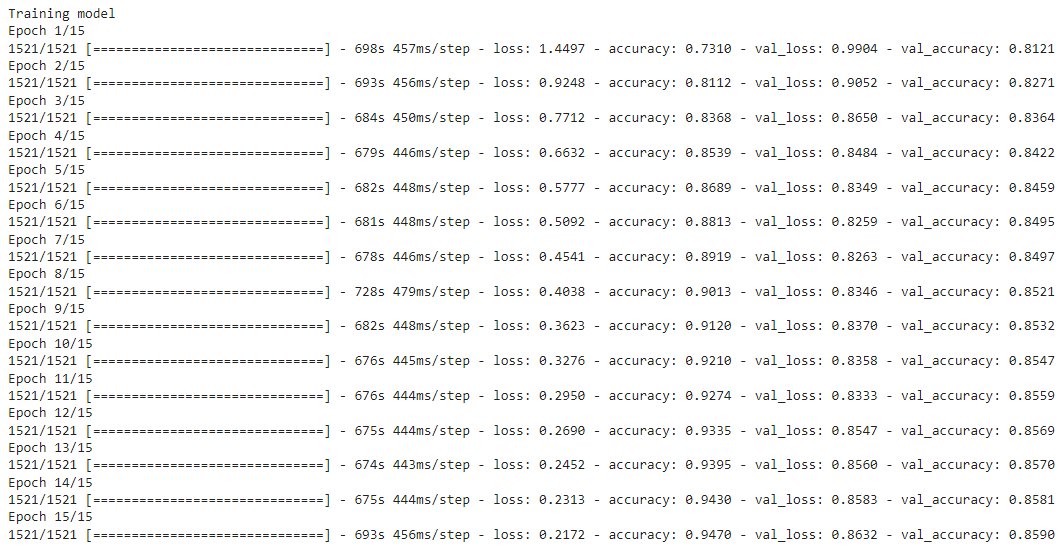

# **Test Set Evaluation**

Here the testing images are imported and face detection/alignment is performed similarly to the training images. One nuance is that the directory is naturally sorted to maintain the numerical ordering required for evaluation once submitted.

In [ ]:
test_data_path = ''

if os.path.isfile('eval_resnet.npz'):
    data_input = np.load('eval_resnet.npz')

    X_eval = data_input['arr_0']
    print('Loaded: ',X_eval.shape)

else:
    print('Generating test data face detections')

    mtcnn = MTCNN(
        image_size = 128, margin=0, post_process=False, device='cuda:0'
    )

    X_eval = []
    for idx, i in enumerate(natsorted(os.listdir(test_data_path))):
        img = Image.open(test_data_path + i).convert('RGB')

        try:
            img_cropped = mtcnn(img)
            img_cropped = img_cropped.cpu().detach().numpy().transpose(1,2,0)
            X_eval.append(np.asarray(img_cropped).astype(np.uint8))
        except:
            X_eval.append(np.asarray(img.resize((128,128))).astype(np.uint8))

    X_eval = np.asarray(X_eval)

    np.savez_compressed('eval_resnet.npz', X_eval)

Loaded:  (4977, 128, 128, 3)


Again due to memory constraints, the cropped testing images are saved to the session storage. The intention is to feed the images in a nearly identical manner as the model was trained to avoid any unexpected pre-processing errors.

In [ ]:
if os.path.isdir('faces/eval'):
    shutil.rmtree('faces/eval')

os.makedirs('faces/eval')

for i in range(len(X_eval)):
    Image.fromarray(X_eval[i]).save('faces/eval/'+ str(i) + '.jpg')

Here, the predictions are generated from the index with the largest probability from the softmax output. The indices are then mapped to the corresponding celebrity names uses the dictionary. This cell is very unoptimized and loops through each image individually; a better approach would be to create batches to predict on, which I've attempted to implement for this notebook. If there are any issues with the 2nd cell, then feel free to uncomment the 1st cell.

In [ ]:
'''
eval_path = 'faces/eval/'
y_pred = []

for idx, i in enumerate(natsorted(os.listdir(eval_path))):
    img = keras.utils.load_img(eval_path+str(i),target_size=(224,224))
    img = np.expand_dims(np.asarray(img),axis=0)

    test = model.predict(preprocess_input(img),verbose = 0)

    y_pred.append(np.argmax(test,axis=1))

y_pred = [model_map[i[0]] for i in y_pred]
'''

In [ ]:
eval_path = 'faces/eval/'

test_generator = validation_datagen.flow_from_directory(
    eval_path,
    target_size = (224,224),
    batch_size = 500,
    shuffle = False,
    classes = ['.'],
    class_mode = 'categorical')

test = model.predict(test_generator,verbose = 0)
y_pred = np.argmax(test,axis=1)

y_pred = [model_map[i[0]] for i in y_pred]

Found 4977 images belonging to 1 classes.


Finally, the submission file is generated!

In [ ]:
name_pred = []
idx_pred = []
for idx, value in enumerate(y_pred):
  name_pred.append(value)
  idx_pred.append(idx)

sub_dict = {'ID': idx_pred, 'Category': name_pred}
submission = pd.DataFrame(data=sub_dict)
submission.to_csv('submission.csv',index=False)